In [ ]:
#Load import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #for LSTM sensitivity to df scale

In [ ]:
import datetime
import yfinance as yf #for historical stock df
from datetime import timedelta


end_date = datetime.datetime.now()
start_date = end_date - timedelta(days=5*365)

print("Downloading historical df...")
df = pd.dfFrame(yf.download('RELIANCE.NS', start=start_date, end=end_date))

df.info()


C:\Users\anany\AppData\Local\Temp\ipykernel_11284\3915450064.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = pd.DataFrame(yf.download('RELIANCE.NS', start=start_date, end=end_date))
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1238 entries, 2020-07-31 to 2025-07-29
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Close, RELIANCE.NS)   1238 non-null   float64
 1   (High, RELIANCE.NS)    1238 non-null   float64
 2   (Low, RELIANCE.NS)     1238 non-null   float64
 3   (Open, RELIANCE.NS)    1238 non-null   float64
 4   (Volume, RELIANCE.NS)  1238 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.0 KB


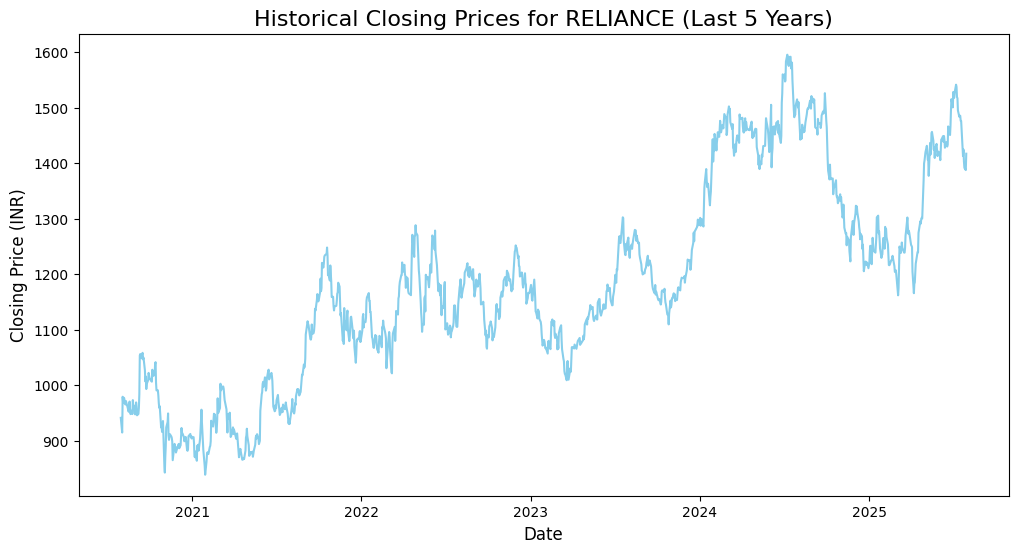

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Closing Price', color='skyblue')

plt.title(f'Historical Closing Prices for RELIANCE (Last 5 Years)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (INR)', fontsize=12)
plt.show()

In [8]:
len(df[df.isna().any(axis=1)]) #no nulls

scaler=MinMaxScaler(feature_range=(0,1))

dataset = df['Close'].values
training_size = int(np.ceil(len(dataset) * .80))

scaler = MinMaxScaler(feature_range=(0, 1))
scaledtrain = scaler.fit_transform(dataset[0:training_size, :])
#cannot use random train-test split for time-series analysis

scaledtest = scaler.transform(dataset[training_size:, :]) #the test set

In [9]:
look_back = 60 #60 day period
def create_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0] #using column 0
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(scaledtrain, look_back)
X_test, y_test = create_dataset(scaledtest, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

model=Sequential()

model.add(LSTM(
    units=50,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1)
)) #50 neurons is enough complexity to form temporal patterns

model.add(Dropout(0.2)) #prevent overfitting

model.add(LSTM(
    units=50,
    return_sequences=False
)) #more depth more abstraction

model.add(Dropout(0.2))

model.add(Dense(units=1,kernel_regularizer=l2(0.01))) #output layer - uses linear activation

print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')
print("\nTraining the model...")
history = model.fit(
    X_train,
    y_train,
    epochs=50,         
    batch_size=32      
)

print("\nModel training completed!")




Training the model...
Epoch 1/50

30/30 [==============================] - 4s 33ms/step - loss: 0.0619
Epoch 2/50
30/30 [==============================] - 1s 35ms/step - loss: 0.0220
Epoch 3/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0191
Epoch 4/50
30/30 [==============================] - 1s 37ms/step - loss: 0.0179
Epoch 5/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0161
Epoch 6/50
30/30 [==============================] - 1s 36ms/step - loss: 0.0146
Epoch 7/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0138
Epoch 8/50
30/30 [==============================] - 1s 38ms/step - loss: 0.0120
Epoch 9/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0113
Epoch 10/50
30/30 [==============================] - 1s 40ms/step - loss: 0.0105
Epoch 11/50
30/30 [==============================] - 1s 43ms/step - loss: 0.0092
Epoch 12/50
30/30 [==============================] - 1s 39ms/step - loss: 0.0086
Epoch 13/50


In [10]:
predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Predictions completed and inverse transformed.")
print("\nFirst 5 predictions (original scale):")
print(predictions[:5].flatten())
print("\nFirst 5 actual values (original scale):")
print(y_test_original[:5].flatten())

6/6 [==============================] - 1s 27ms/step
Predictions completed and inverse transformed.

First 5 predictions (original scale):
[1326.5353 1324.9264 1325.6876 1325.0906 1325.3525]

First 5 actual values (original scale):
[1340.         1343.90002441 1332.05004883 1338.65002441 1302.15002441]


In [11]:
import math
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_original, predictions)
rmse = math.sqrt(mse)

print(f"\n--- Model Performance Metrics ---")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")



--- Model Performance Metrics ---
Mean Squared Error (MSE): 923.10
Root Mean Squared Error (RMSE): 30.38


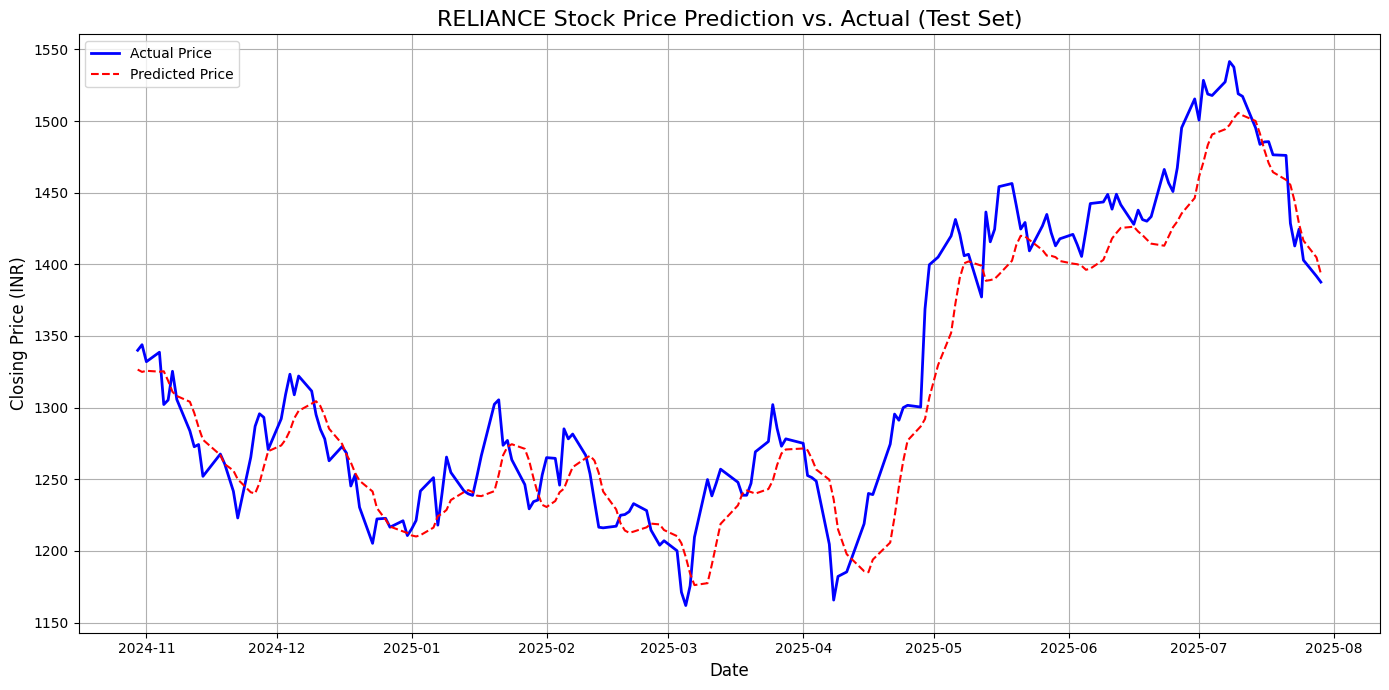

In [ ]:
test_dates = df.index[training_size + look_back + 1:]

test_results = pd.dfFrame(index=test_dates)
test_results['Actual'] = y_test_original
test_results['Predicted'] = predictions

plt.figure(figsize=(14, 7))
plt.plot(test_results['Actual'], label='Actual Price', color='blue', linewidth=2)
plt.plot(test_results['Predicted'], label='Predicted Price', color='red', linestyle='--')
plt.title('RELIANCE Stock Price Prediction vs. Actual (Test Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price (INR)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
